In [1]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import os

#define dataset for diffuser
class CovidDataset(Dataset):
    def __init__(self, root):
        self.path = [os.path.join(root, p) for p in os.listdir(root)]
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        img = Image.open(self.path[idx]).convert("RGB")
        return self.transform(img)

In [2]:
import torch
from torch.utils.data import DataLoader
from diffusers import UNet2DModel, DDPMScheduler
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

dataset = CovidDataset(root="./covid_only_train")
loader = DataLoader(dataset, batch_size=16, shuffle=True)

#define diffusion model
model = UNet2DModel(
    sample_size=64,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )

).to(device)


c:\Users\TYC\Desktop\python code\pneumonia_disease_agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
#define scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

#100 epochs
EPOCHS = 100

In [4]:
#training loop

for epoch in range(EPOCHS):
    model.train()
    pbar = tqdm(loader)

    for batch in pbar:
        batch = batch.to(device)
        noise = torch.randn_like(batch)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (batch.size(0),), device=device).long()

        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        pred = model(noisy, timesteps).sample
        loss = torch.nn.functional.mse_loss(pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Epoch {epoch} | Loss {loss.item():.4f}")
        

  0%|          | 0/17 [00:00<?, ?it/s]c:\Users\TYC\Desktop\python code\pneumonia_disease_agent\.venv\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 0 | Loss 0.0864: 100%|██████████| 17/17 [00:10<00:00,  1.60it/s]
Epoch 1 | Loss 0.0755: 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Epoch 2 | Loss 0.0439: 100%|██████████| 17/17 [00:07<00:00,  2.41it/s]
Epoch 3 | Loss 0.0759: 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]
Epoch 4 | Loss 0.0269: 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
Epoch 5 | Loss 0.0460: 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
Epoch 6 | Loss 0.0784: 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
Epo

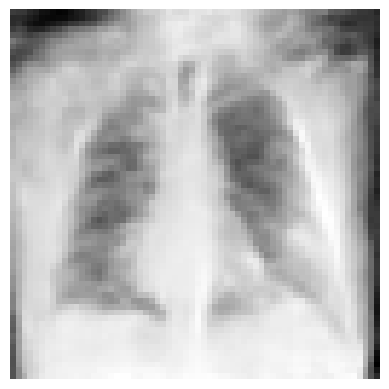

In [6]:
#visualize results
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    sample = torch.randn(1, 1, 64, 64).to(device)
    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(sample, t).sample
        sample = noise_scheduler.step(noise_pred, t, sample).prev_sample

    sample = (sample.clamp(-1, 1) + 1) / 2
    sample = sample.cpu().permute(0, 2, 3, 1).numpy()[0]

    plt.imshow(sample.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
#save model
torch.save(model.state_dict(), "covid_diffuser.pt")

In [ ]:
#generate samples
from torchvision.utils import save_image

model.eval()
os.makedirs("covid_only_generated", exist_ok=True)

num_images = 280
for i in range(num_images):
    img = torch.randn((1, 1, 64, 64)).to(device)
    
    if i % 20 == 0:
        print(f"Generating image {i}/{num_images}")

    for t in noise_scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(img, t).sample
        img = noise_scheduler.step(noise_pred, t, img).prev_sample
    
    save_image(
        (img + 1) / 2,
        f"covid_only_generated/generated_{i}.jpg"
    )

Generating image 0/1000


KeyboardInterrupt: 